## RFM Segmentation on E-Commerce Data

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In [1]:
import time
import pandas as pd
import numpy as np
import statistics
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re

In [2]:
from random import sample
from numpy.random import uniform
from math import isnan

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [4]:
#This is to ring a bell when the code is done
import os

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
ecomm_df = pd.read_csv("data.csv", encoding= 'unicode_escape')

In [7]:
ecomm_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
ecomm_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Handling Null Values

In [9]:
ecomm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Let's check if Description values can be obtained from the StockCode column

In [10]:
stockCode_groupby = ecomm_df.groupby(['StockCode'])
stockCode_groupby[['StockCode', 'Description']].get_group('85123A').value_counts()

StockCode  Description                       
85123A     WHITE HANGING HEART T-LIGHT HOLDER    2302
           CREAM HANGING HEART T-LIGHT HOLDER       9
           wrongly marked carton 22804              1
           ?                                        1
dtype: int64

There is more than one description for a given stock code.

In [11]:
#Checking if the number of descriptions is far higher than the number of stock codes
print(len(ecomm_df['StockCode'].value_counts()))
print(len(ecomm_df[['StockCode', 'Description']].value_counts()))

4070
4792


The number of descriptions is not drastically higher than the number of stock codes (as seen in the sample stock code above). I'll impute the mode description value for a given stock code.

In [12]:
#Creating a group by object, in order to get the mode
grouped_StockCode = ecomm_df.groupby('StockCode')

#Making a list of stock codes in the train set
stockCode_list = list(ecomm_df['StockCode'].unique())

In [13]:
start_time = time.time()

In [14]:
dict_stockCode_mode = {}

#Creating a dictionary that contains the Description mode value for each Stock Code
for i in stockCode_list:
    dict_stockCode_mode[i] = statistics.mode(grouped_StockCode['Description'].get_group(i))

In [15]:
#Triggering garbage collection
gc.collect()

80

In [16]:
#Imputing the mode Description value for each StockCode

ecomm_df['Description'] = ecomm_df.apply(lambda x: dict_stockCode_mode[x['StockCode']] 
                             if (pd.isnull(x['Description'])) else x['Description'], axis=1)

In [17]:
print("Time taken (in seconds): ", time.time()-start_time)

Time taken (in seconds):  7.22204852104187


In [18]:
ecomm_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [19]:
ecomm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  541755 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [20]:
#Checking for null values in the Description column
bool_Description = pd.isnull(ecomm_df['Description'])

#Listing the stock codes where the description is null
list_StockCode_nullDescription = list(set(ecomm_df['StockCode'][bool_Description]))
print("Number of stock codes with at least one missing value in description column: ", len(list_StockCode_nullDescription))

Number of stock codes with at least one missing value in description column:  133


In [21]:
#Creating a group by object
grouped_StockCode = ecomm_df.groupby('StockCode')

In [22]:
#Viewing the descriptions where at least one description for a stock code is null
for i in list_StockCode_nullDescription:
    print("StockCode: ", i)
    print(grouped_StockCode['Description'].get_group(i), "\n\n")

StockCode:  62095B
21786    NaN
Name: Description, dtype: object 


StockCode:  84876C
145260    NaN
Name: Description, dtype: object 


StockCode:  21337
149043    NaN
Name: Description, dtype: object 


StockCode:  84509F
75239    NaN
Name: Description, dtype: object 


StockCode:  22143
75232    NaN
Name: Description, dtype: object 


StockCode:  90037D
172877    NaN
Name: Description, dtype: object 


StockCode:  84664
75241    NaN
Name: Description, dtype: object 


StockCode:  10134
146980    NaN
Name: Description, dtype: object 


StockCode:  72800F
143302    NaN
Name: Description, dtype: object 


StockCode:  35015
143304    NaN
Name: Description, dtype: object 


StockCode:  DCGS0066P
279257    NaN
Name: Description, dtype: object 


StockCode:  85226C
172868    NaN
Name: Description, dtype: object 


StockCode:  90091
75294    NaN
Name: Description, dtype: object 


StockCode:  90095
75293    NaN
Name: Description, dtype: object 


StockCode:  20864
75223    NaN
Name: Descrip

There are a few descriptions that are not mode values, but can be imputed for the null values with the corresponding Stock Codes.

In [23]:
#Imputing the descriptions that are not mode values

for i in list_StockCode_nullDescription:
    
    #Getting the descriptions for this stock code
    check_descriptions = len(set(ecomm_df['Description'][(pd.notnull(ecomm_df['Description'])) & (ecomm_df['StockCode']==i)]))
    
    #Checking if there is atleast one non-null description available for this stock code
    if check_descriptions > 0:
        
        #Getting the description for this stock code
        description_value = list(set(ecomm_df['Description'][(pd.notnull(ecomm_df['Description'])) & (ecomm_df['StockCode']==i)]))
        
        #Imputing this description value
        ecomm_df.loc[(ecomm_df['StockCode']==i) & (pd.isnull(ecomm_df['Description'])), 'Description'] = description_value[0]


In [24]:
ecomm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  541797 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


The number of non-null rows in the Description column has decreased.

In [25]:
#Discarding the rows that don't contain CustomerIDs, as they are necessary for customer segmentation
ecomm_df = ecomm_df[pd.notnull(ecomm_df['CustomerID'])]
ecomm_df.shape

(406829, 8)

In [26]:
#Also converting the CustomerID column into an int column
ecomm_df['CustomerID'] = ecomm_df['CustomerID'].astype(int)

In [27]:
ecomm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  int32  
 7   Country      406829 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 26.4+ MB


## Data Exploration and Preparation

In [28]:
ecomm_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [29]:
#Getting a description of the non-numerical columns
ecomm_df.describe(exclude="number")

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,406829,406829,406829,406829,406829
unique,22190,3684,3896,20460,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,11/14/2011 15:27,United Kingdom
freq,542,2077,2070,543,361878


In [30]:
#Getting a description of the numerical columns
ecomm_df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Taking a look at the Country column

In [31]:
#Checking the percentage of invoices from each country
ecomm_df['Country'].value_counts(normalize=True)

United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RSA       

Checking if there is a big variation in the percentage of invoices from each country when only the highest 1% unit prices are considered

In [32]:
ecomm_df['Country'][ecomm_df['UnitPrice'] > ecomm_df['UnitPrice'].quantile(0.99)].value_counts(normalize=True)

United Kingdom          0.612461
Germany                 0.115047
France                  0.093330
EIRE                    0.046794
Spain                   0.024302
Belgium                 0.012151
Finland                 0.011634
Portugal                0.011634
Switzerland             0.010858
Italy                   0.009824
Norway                  0.009307
Sweden                  0.006205
Cyprus                  0.005429
Austria                 0.005429
Channel Islands         0.004395
Singapore               0.004137
Netherlands             0.004137
Denmark                 0.003361
Poland                  0.002327
Malta                   0.001293
Greece                  0.001293
Israel                  0.001034
Unspecified             0.000776
Japan                   0.000776
Australia               0.000517
USA                     0.000517
European Community      0.000259
Canada                  0.000259
United Arab Emirates    0.000259
Czech Republic          0.000259
Name: Coun

There are some changes when only the items with the top 1% unit price are considered, but the countries that have currencies with a higher exchange rate are still at the top of that list. This suggests that the unit price column contains information in one currency only. Therefore, currency conversion is not required and customer segmentation can be performed for all these rows.

In [33]:
ecomm_df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


There are invoices with negative quantities. These are likely to be due to cancelled or returned items. We need to check if there are positive quantities that correspond to these negative values, since that will affect the total amount purchased by a customer (which is the 'M' in RFM segmentation).

In [34]:
#Checking the number of rows where the Quantity is less than zero
ecomm_df[ecomm_df['Quantity'] < 0].shape[0]

8905

In [35]:
#Checking if the invoice number of returned/cancelled items matches with invoice numbers where the quantity is > 0
ecomm_df[ecomm_df['InvoiceNo'].isin(ecomm_df['InvoiceNo'][ecomm_df['Quantity'] < 0])].shape[0]

8905

The number of rows in both is the same, which suggests that cancellations/returns have different invoice numbers from the original purchase. Next, let's check if customers have purchased the items that they've returned.

Let's start by collecting the Customer_ID and StockCode of all the items that were returned.

In [36]:
#Creating a temporary dataframe of the customer ID and stock code columns for rows with returns
temp_df_negative_quantity = ecomm_df[['CustomerID', 'StockCode']][ecomm_df['Quantity'] < 0]

#Zipping the two columns of the dataframe together to get a list of tuples
list_zipped_negative = list(zip(list(temp_df_negative_quantity['CustomerID']), list(temp_df_negative_quantity['StockCode'])))
len(list_zipped_negative)

8905

Next, let's collect all the data points that are not returns and drop duplicate rows.

In [37]:
#Creating a temporary dataframe of the customer ID and stock code for rows without returns
temp_df_positive_quantity = ecomm_df[['CustomerID', 'StockCode']][ecomm_df['Quantity'] > 0]

#Dropping duplicates to exclude items that were purchased more than once by the same customer
temp_df_positive_quantity = temp_df_positive_quantity.drop_duplicates()

print(temp_df_positive_quantity.shape)
temp_df_positive_quantity.head(3)

(266802, 2)


,CustomerID,StockCode
0,17850,85123A
1,17850,71053
2,17850,84406B


Now, we can create a list of the CustomerID and StockCode values of items that were returned but don't have a record of being purchased.

In [38]:
#Using list comprehension for this
list_unpurchased = [i for i in list_zipped_negative if i not in zip(temp_df_positive_quantity['CustomerID'], temp_df_positive_quantity['StockCode'])]

In [39]:
print('Number of items that were returned: ', len(list_zipped_negative))
print('Number of items that were returned but without a record of having been purchased: ', len(list_unpurchased))

Number of items that were returned:  8905
Number of items that were returned but without a record of having been purchased:  948


Since our dataframe only contains ~1 year of data, there could be items that were returned in this period, but were purchased earlier. This would explain why we have records of items being returned, but not of them being purchased.

In RFM analysis, we calculate each customer's total purchase amount. Therefore, we should include the returns for which we have records of purchase, as these could impact a customer's total purchase amount. However, let's drop the rows that indicate returns without record of purchase.

In [40]:
#In order to check if two columns of a dataframe match a pair of values, let's concatenate the two columns

#Concatenating the individual tuples in our list
list_concatenated_unpurchased = [str(i) + str(j) for i, j in list_unpurchased]

#Concatenating the two columns in our dataframe and converting the resulting list into a series
df_concatenated_all = pd.Series([str(i) + str(j) for i, j in ecomm_df[['CustomerID', 'StockCode']].values])

In [41]:
#Checking the format of the list with the concatenated 
list_concatenated_unpurchased[:3]

['14527D', '1754822556', '1754821984']

In [42]:
#Checking the dimensions of the two objects
print(df_concatenated_all.shape)
print(len(list_concatenated_unpurchased))

(406829,)
948


In [44]:
#Resetting the index of the dataframe as we dropped ~100,000 rows (which had null values in the Customer_ID column)
ecomm_df.reset_index(inplace=True, drop=True)

In [45]:
#Checking if the number of rows selected here is the same as what we have in our list

print("Number of rows selected in dataframe: ", ecomm_df[df_concatenated_all.isin(list_concatenated_unpurchased)].shape[0])
print("Length of list: ", len(list_unpurchased))

Number of rows selected in dataframe:  948
Length of list:  948


Since these values match, let's go ahead and drop rows from the dataframe.

In [46]:
#Checking the shape of the dataframe before dropping rows
ecomm_df.shape

(406829, 8)

In [47]:
#Retaining only the rows that are not in the list of unpurchased items
ecomm_df = ecomm_df[~df_concatenated_all.isin(list_concatenated_unpurchased)]
ecomm_df.shape

(405881, 8)

948 rows have been dropped.

Next, let's calculate the amount spent by a customer on each purchase.

In [48]:
ecomm_df['Amount'] = ecomm_df['Quantity'] * ecomm_df['UnitPrice']
ecomm_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34


In [49]:
ecomm_df.describe()

,Quantity,UnitPrice,CustomerID,Amount
count,405881.000000,405881.000000,405881.000000,405881.000000
mean,12.140746,3.259453,15287.843939,20.694487
std,248.521147,28.871495,1713.839674,423.362096
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,2.000000,1.250000,13952.000000,4.200000
50%,5.000000,1.950000,15152.000000,11.250000
75%,12.000000,3.750000,16791.000000,19.500000
max,80995.000000,8142.750000,18287.000000,168469.600000


The unit price is zero in some rows. Let's take a closer look at this.

In [50]:
#Viewing the rows where the UnitPrice is zero or lower
ecomm_df[ecomm_df['UnitPrice']<=0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
7012,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647,Germany,0.0
23071,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560,United Kingdom,0.0
26046,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911,EIRE,0.0
29881,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081,United Kingdom,0.0
29883,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081,United Kingdom,0.0
35460,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,1/13/2011 15:10,0.0,15107,United Kingdom,0.0
55279,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2/10/2011 13:08,0.0,17560,United Kingdom,0.0
87903,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,3/23/2011 10:25,0.0,13239,United Kingdom,0.0
95201,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,3/30/2011 12:45,0.0,13113,United Kingdom,0.0
99945,548871,22162,HEART GARLAND RUSTIC PADDED,2,4/4/2011 14:42,0.0,14410,United Kingdom,0.0


There are no rows with negative UnitPrice values. Zero UnitPrice could indicate that the item was given for free. However, there are cases where the unit price is zero for hundreds of items. Let's check the total invoiced amount when there are free items included.

In [51]:
#Selecting the invoice numbers that have at least one free item in the invoice
#Grouping this selection by the invoice number and summing the amount for each invoice number
ecomm_df[ecomm_df['InvoiceNo'].isin(list(ecomm_df['InvoiceNo'][ecomm_df['UnitPrice']==0]))].groupby(by='InvoiceNo')['Amount'].sum()

InvoiceNo
537197     286.50
539263     332.18
539722     762.30
540372    3527.64
541109      14.95
543599       0.00
547417     329.56
548318     453.05
548871      91.48
550188     669.25
553000      62.12
554037     766.36
561284      87.96
561669     811.90
561916     250.00
562973    1234.00
564651       0.00
568158    1146.80
568384       0.00
569716     223.22
571035    1002.31
572893      95.78
574138     375.24
574175      41.60
574252     260.48
574469     601.44
574879      76.50
574920     418.26
575579      72.00
577129      46.80
577168     739.20
577314     936.64
577696     163.07
578841       0.00
Name: Amount, dtype: float64

As seen here, most invoices have a positive total amount. There are a few with zero total amount. These could be because the free items have been billed under a separate invoice. It could also be because some items have been given as free items even when a customer did not make a purchase (this can be verified with the client).

In [52]:
ecomm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405881 entries, 0 to 406828
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    405881 non-null  object 
 1   StockCode    405881 non-null  object 
 2   Description  405881 non-null  object 
 3   Quantity     405881 non-null  int64  
 4   InvoiceDate  405881 non-null  object 
 5   UnitPrice    405881 non-null  float64
 6   CustomerID   405881 non-null  int32  
 7   Country      405881 non-null  object 
 8   Amount       405881 non-null  float64
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 29.4+ MB


The InvoiceDate column is of float type, but seems to contain date information in a recognisable date format. This column can be converted to a datetime object.

In [53]:
ecomm_df['InvoiceDate'] = pd.to_datetime(ecomm_df['InvoiceDate'])
ecomm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405881 entries, 0 to 406828
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    405881 non-null  object        
 1   StockCode    405881 non-null  object        
 2   Description  405881 non-null  object        
 3   Quantity     405881 non-null  int64         
 4   InvoiceDate  405881 non-null  datetime64[ns]
 5   UnitPrice    405881 non-null  float64       
 6   CustomerID   405881 non-null  int32         
 7   Country      405881 non-null  object        
 8   Amount       405881 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 29.4+ MB


In [54]:
ecomm_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


To calculate recency, the most recent invoice number of each customer is required.

In [55]:
#Grouping by the customer ID column to find each customer's most recent invoice
#Note that this is a good way to get a dataframe (instead of a groupby object) that contains the info needed
recency_df = ecomm_df.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
recency_df.head()

,CustomerID,InvoiceDate
0,12346,2011-01-18 10:17:00
1,12347,2011-12-07 15:52:00
2,12348,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


In [56]:
#Converting the InvoiceDate column to a date object
recency_df['InvoiceDate'] = recency_df['InvoiceDate'].apply(lambda x: x.date())

#Renaming the InvoiceDate column
recency_df.columns = ['CustomerID', 'MostRecentPurchaseDate']
recency_df.head()

,CustomerID,MostRecentPurchaseDate
0,12346,2011-01-18
1,12347,2011-12-07
2,12348,2011-09-25
3,12349,2011-11-21
4,12350,2011-02-02


Recency is the number of days since the last purchase. This can be calculated from the MostRecentPurchaseDate column.

In [57]:
#Finding the most recent and the oldest dates in the column
print(max(recency_df['MostRecentPurchaseDate']))
print(min(recency_df['MostRecentPurchaseDate']))

2011-12-09
2010-12-01


In [58]:
#Setting a date that will be used to calculate number of days for the recency column
today = dt.date(2011, 12, 10)
print(today)

2011-12-10


In [59]:
#Calculating the Recency values
recency_df['Recency'] = recency_df['MostRecentPurchaseDate'].apply(lambda x: (today-x).days)

#Note: recency = today - mostrecentpurchasedate is also possible, but the result is a timedelta object.
#The code above gives results in int

In [60]:
#Dropping the MostRecentPurchaseDate column, as its no longer needed
recency_df.drop('MostRecentPurchaseDate', axis = 1, inplace=True)
recency_df.head()

,CustomerID,Recency
0,12346,326
1,12347,3
2,12348,76
3,12349,19
4,12350,311


Next, let's calculate the Frequency values for each customer. Frequency is the number of times the customer has transacted in the given period.

In [61]:
ecomm_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


Since each row represents an item purchased by a customer, the invoice number is repeated (along with the same invoice date) for a customer. This indicates that the customer billed multiple items together.

In [62]:
#Counting the number of unique invoice numbers to determine the number of transactions made by the customer
frequency_df = ecomm_df.groupby(by='CustomerID', as_index=False)['InvoiceNo'].count()
frequency_df.head()

,CustomerID,InvoiceNo
0,12346,2
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [63]:
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346,2
1,12347,182
2,12348,31
3,12349,73
4,12350,17


And finally, let's calulate the values of the Monetary column.

In [64]:
monetary_df = ecomm_df.groupby(by='CustomerID', as_index=False)['Amount'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


The next step is to merge these three dataframes.

In [65]:
#Checking if all three dataframes have the same number of rows (one row for each customer)
print(recency_df.shape)
print(frequency_df.shape)
print(monetary_df.shape)

(4339, 2)
(4339, 2)
(4339, 2)


In [66]:
rfm_df = recency_df.merge(frequency_df, on='CustomerID')
rfm_df = rfm_df.merge(monetary_df, on='CustomerID')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,0.00
1,12347,3,182,4310.00
2,12348,76,31,1797.24
3,12349,19,73,1757.55
4,12350,311,17,334.40


In [67]:
rfm_df.describe()

,CustomerID,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,91.372667,93.542521,1935.814474
std,1721.889758,99.484168,232.820749,8339.408230
min,12346.000000,1.000000,1.000000,-451.420000
25%,13812.500000,17.000000,18.000000,302.185000
50%,15299.000000,50.000000,42.000000,657.230000
75%,16778.500000,140.000000,102.000000,1624.130000
max,18287.000000,374.000000,7974.000000,279801.020000


From this table, we can see that both the Monetary and Frequency columns have outliers. Let's check all three columns for outliers.

## Outlier Treatment

The K-Means algorithm is sensitive to outliers. Let's visualize the distribution of all three columns to check for outliers.

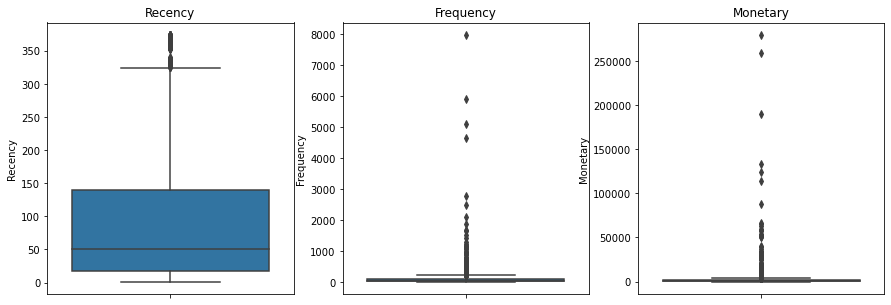

In [68]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Recency")
sns.boxplot(y=rfm_df['Recency'])

plt.subplot(1, 3, 2)
plt.title("Frequency")
sns.boxplot(y=rfm_df['Frequency'])

plt.subplot(1, 3, 3)
plt.title("Monetary")
sns.boxplot(y=rfm_df['Monetary'])

plt.show()

The boxplots show that all three columns contain outliers, although the outliers are far more distant in the frequency and monetary columns.

In [69]:
#Checking the number of rows in the dataframe before performing outlier treatment
rfm_df.shape[0]

4339

Let's start by removing the outliers in the monetary column

In [70]:
#Calculating the lower and upper quartiles and the interquartile range
q1_mon = rfm_df['Monetary'].quantile(0.25)
q3_mon = rfm_df['Monetary'].quantile(0.75)
inter_qr_mon = q3_mon - q1_mon

#Retaining only the values that are within 1.5*interquartile range (the whiskers on the boxplot)
rfm_df = rfm_df[(rfm_df['Monetary'] >= (q1_mon - inter_qr_mon*1.5)) 
                & (rfm_df['Monetary'] <= (q3_mon + inter_qr_mon*1.5))]
rfm_df.shape[0]

3917

Removing the outliers in the frequency column next

In [71]:
#Calculating the lower and upper quartiles and the interquartile range
q1_freq = rfm_df['Frequency'].quantile(0.25)
q3_freq = rfm_df['Frequency'].quantile(0.75)
inter_qr_freq = q3_freq - q1_freq

#Retaining only the values that are within 1.5*interquartile range (the whiskers on the boxplot)
rfm_df = rfm_df[(rfm_df['Frequency'] >= (q1_freq - inter_qr_freq*1.5)) 
                & (rfm_df['Frequency'] <= (q3_freq + inter_qr_freq*1.5))]
rfm_df.shape[0]

3665

I'm discarding a lot of rows (4372 - 3665 = 707) as the k-means clustering algorithm is very sensitive to outliers.

Plotting boxplots of all three columns again

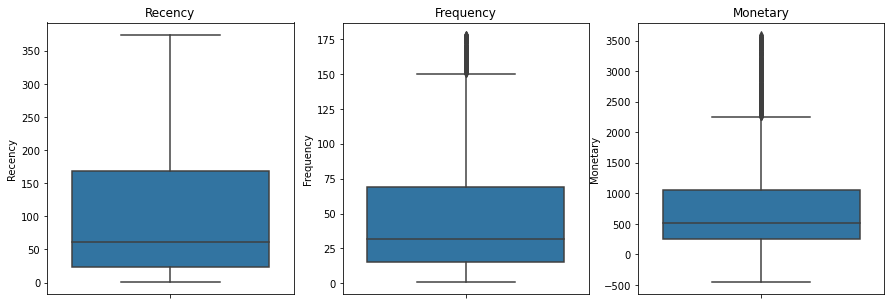

In [72]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Recency")
sns.boxplot(y=rfm_df['Recency'])

plt.subplot(1, 3, 2)
plt.title("Frequency")
sns.boxplot(y=rfm_df['Frequency'])

plt.subplot(1, 3, 3)
plt.title("Monetary")
sns.boxplot(y=rfm_df['Monetary'])

plt.show()

In [73]:
rfm_df.describe()

,CustomerID,Recency,Frequency,Monetary
count,3665.000000,3665.000000,3665.000000,3665.000000
mean,15307.944065,103.476398,47.016098,783.377996
std,1717.335105,102.497825,41.699048,738.137084
min,12346.000000,1.000000,1.000000,-451.420000
25%,13821.000000,23.000000,15.000000,256.380000
50%,15307.000000,61.000000,32.000000,517.530000
75%,16788.000000,169.000000,69.000000,1053.490000
max,18287.000000,374.000000,178.000000,3595.480000


The max values are not too far from the 75% percentile values now.

### Scaling the variables

In [74]:
#Making a copy of the dataframe before scaling the variables
rfm_df_copy = rfm_df.copy(deep=True)
rfm_df_copy.reset_index(drop=True, inplace=True)     #drop=True avoids putting the index as a column of the df
rfm_df_copy.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,0.00
1,12348,76,31,1797.24
2,12349,19,73,1757.55
3,12350,311,17,334.40
4,12352,37,95,1545.41


In [75]:
rfm_df = rfm_df[['Recency', 'Frequency', 'Monetary']]
rfm_df.head()

,Recency,Frequency,Monetary
0,326,2,0.00
2,76,31,1797.24
3,19,73,1757.55
4,311,17,334.40
5,37,95,1545.41


In [76]:
#Creating a min max scaler object
scaler = MinMaxScaler()

In [77]:
#Scaling the columns
rfm_df = scaler.fit_transform(rfm_df)

In [78]:
rfm_df = pd.DataFrame(rfm_df)
rfm_df.columns = ['Recency', 'Frequency', 'Monetary']
rfm_df.head()

,Recency,Frequency,Monetary
0,0.871314,0.005650,0.111547
1,0.201072,0.169492,0.555650
2,0.048257,0.406780,0.545842
3,0.831099,0.090395,0.194178
4,0.096515,0.531073,0.493422


## Model Building

### Hopkin's Statistic

Hopkin's statistic gives the cluster tendency of the data (i.e., the feasibility of the data for clustering). 
- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [79]:
rfm_df.values.shape

(3665, 3)

In [80]:
#Defining a function to calculate the Hopkin's statistic

def hopkins(X):
    
    d = X.shape[1]        #no. of columns
    n = len(X)            #no. of rows
    m = int(0.1 * n)      #sample size is 10% of dataset size
    

    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)      
    #X.values returns the dataframe's values in an array of the same shape
    #Searching for each data point's nearest neighbour (as n_neighbors=1)
 

    rand_X = sample(range(0, n, 1), m)                        
    #Picking 'm' sample data points
 

    #Initalizing empty lists to store distances
    ujd = []   
    wjd = []
    
    
    for j in range(0, m):
        
        #Calculating nearest neighbour distances from uniformly generated sample points to sample data from the dataset
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        
        #Calculating nearest neighbour distances within the sample data from the dataset
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
    
    #Calculating the Hopkin's statistic
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [81]:
#Getting the Hopkin's statistic value for this dataset
hopkins(rfm_df)

0.858346835270025

Since this value is close to 1, it indicates that the dataset has a high tendency to cluster.

### Silhouette Analysis 

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data points are very similar to other data points in the cluster.

* A score closer to -1 indicates that the data points are not similar to the data points in the cluster.

In [82]:
#Fitting multiple KMeans models with a different number of clusters
sha = []
for k in range(2, 10):
    kmeans_sha = KMeans(n_clusters=k, max_iter=50, n_jobs=-1).fit(rfm_df)
    sha.append([k, silhouette_score(rfm_df, kmeans_sha.labels_)])

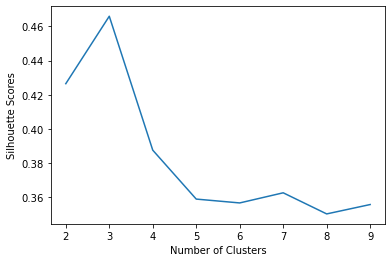

In [83]:
#Plotting the silhouette score and the number of clusters in these models

#Since sha is a nested list, converting it to a dataframe to get the no. of clusters in one col and scores in the other
plt.plot(pd.DataFrame(sha)[0], pd.DataFrame(sha)[1])
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Scores")
plt.show()

From this graph, we can see that the silhouette score is highest for the model with three clusters. This suggests that a model with three clusters is likely to work best.

### Sum of Squared Distances

This is the sum of each data point's squared distance from its closest cluster center. Lower numbers are better, but we will get lower numbers if we increase the number of clusters. However, increasing the number of clusters may not make sense from a business perspective, so we need to strike a balance between number of clusters and sum of squared distances.

In [84]:
#Fitting several KMeans models with a different number of clusters
ssd = []
for num_clusters in list(range(1,15)):
    model_ssd = KMeans(n_clusters = num_clusters, max_iter=50, n_jobs=-1).fit(rfm_df)
    ssd.append(model_ssd.inertia_)
    #The inertia attribute returns the sum of squared distances of samples to their closest cluster center

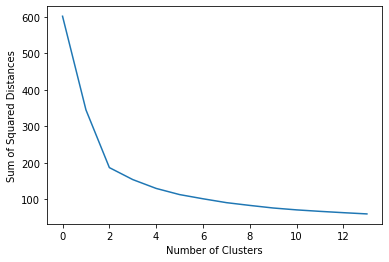

In [85]:
#Plotting the sum of squared distances (inertia) and the number of clusters in these models
plt.plot(ssd)
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances")
plt.show()

The elbow of the curve seems to lie between 2 and 4 on the x-axis (number of clusters).

### Hierarchical Clustering

In a dendrogram, the greater the height of the link between two points, the lesser the similarity between those two points.

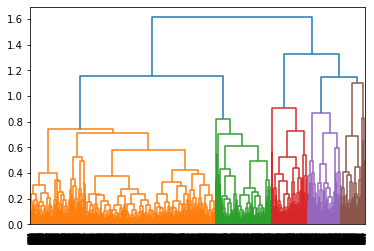

In [86]:
#Using the complete linkage method (distance between two clusters is defined as the max distance between any two points in the clusters)
mergings = linkage(rfm_df, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

The dendrogram above suggests that this dataset can be grouped into 3 or 5 clusters.

Based on the analysis so far, it looks like 3 clusters is the best option. Let's fit a model with 3 clusters.

In [87]:
#Creating a K-Means object with 3 clusters
kmeans = KMeans(n_jobs = -1, n_clusters = 3, init='k-means++', n_init = 100, max_iter = 1000, random_state=100)

#n_init is the number of times kmeans will run with different centroid initializations. 
#The best output (based on inertia) will be chosen.

#max_iter is the maximum number of iterations of the k-means algorithm for a single run

Using k-means++ for initialization here as that usually works best. In k-means++, after picking a random point as the first centroid, the next centroid is the point that's farthest away from the centroid that's already selected.

In [88]:
#Fitting the model
kmeans.fit(rfm_df)

KMeans(max_iter=1000, n_clusters=3, n_init=100, n_jobs=-1, random_state=100)

In [89]:
#Making predictions on which cluster each data point should belong to
pred = kmeans.predict(rfm_df)

Before storing the cluster predictions, let's check the rfm_df dataframe.

In [90]:
rfm_df.head()

,Recency,Frequency,Monetary
0,0.871314,0.005650,0.111547
1,0.201072,0.169492,0.555650
2,0.048257,0.406780,0.545842
3,0.831099,0.090395,0.194178
4,0.096515,0.531073,0.493422


The CustomerID column also needs to be added to this dataframe. Also, the original RFM values are needed, so these columns need to be renamed.

In [91]:
rfm_df.columns = ['R_scaled', 'F_scaled', 'M_scaled']
rfm_df.head()

,R_scaled,F_scaled,M_scaled
0,0.871314,0.005650,0.111547
1,0.201072,0.169492,0.555650
2,0.048257,0.406780,0.545842
3,0.831099,0.090395,0.194178
4,0.096515,0.531073,0.493422


In [92]:
#Checking the copy of the rfm_df dataframe for the original RFM values
rfm_df_copy.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,0.00
1,12348,76,31,1797.24
2,12349,19,73,1757.55
3,12350,311,17,334.40
4,12352,37,95,1545.41


In [93]:
#Concatenating these two dataframes
rfm_df_cluster = pd.concat([rfm_df_copy, rfm_df], axis=1)
rfm_df_cluster.head()

,CustomerID,Recency,Frequency,Monetary,R_scaled,F_scaled,M_scaled
0,12346,326,2,0.00,0.871314,0.005650,0.111547
1,12348,76,31,1797.24,0.201072,0.169492,0.555650
2,12349,19,73,1757.55,0.048257,0.406780,0.545842
3,12350,311,17,334.40,0.831099,0.090395,0.194178
4,12352,37,95,1545.41,0.096515,0.531073,0.493422


In [94]:
#Creating a new column in the dataframe to store the predictions
rfm_df_cluster['Cluster'] = pred
rfm_df_cluster.head()

,CustomerID,Recency,Frequency,Monetary,R_scaled,F_scaled,M_scaled,Cluster
0,12346,326,2,0.00,0.871314,0.005650,0.111547,1
1,12348,76,31,1797.24,0.201072,0.169492,0.555650,0
2,12349,19,73,1757.55,0.048257,0.406780,0.545842,2
3,12350,311,17,334.40,0.831099,0.090395,0.194178,1
4,12352,37,95,1545.41,0.096515,0.531073,0.493422,2


In [95]:
#Adding '1' to all the cluster labels, so that there is no zeroth cluster
rfm_df_cluster['Cluster'] = rfm_df_cluster['Cluster'] + 1
rfm_df_cluster.head()

,CustomerID,Recency,Frequency,Monetary,R_scaled,F_scaled,M_scaled,Cluster
0,12346,326,2,0.00,0.871314,0.005650,0.111547,2
1,12348,76,31,1797.24,0.201072,0.169492,0.555650,1
2,12349,19,73,1757.55,0.048257,0.406780,0.545842,3
3,12350,311,17,334.40,0.831099,0.090395,0.194178,2
4,12352,37,95,1545.41,0.096515,0.531073,0.493422,3


Next, let's take a look at the mean Recency, Frequency, and Monetary values in each cluster.

In [96]:
#Recency mean
clusters_r_mean = rfm_df_cluster.groupby(by = 'Cluster', as_index = True)['Recency'].mean()
clusters_r_mean

Cluster
1     53.050267
2    254.314642
3     42.225962
Name: Recency, dtype: float64

In [97]:
#Frequency mean
clusters_f_mean = rfm_df_cluster.groupby(by = 'Cluster', as_index = True)['Frequency'].mean()
clusters_f_mean

Cluster
1     31.470053
2     22.452752
3    110.388221
Name: Frequency, dtype: float64

In [98]:
#Monetary mean
clusters_m_mean = rfm_df_cluster.groupby(by = 'Cluster', as_index = True)['Monetary'].mean()
clusters_m_mean

Cluster
1     575.193301
2     367.066023
3    1733.154208
Name: Monetary, dtype: float64

In [100]:
#Combining these three into one dataframe
cluster_means = pd.concat([clusters_r_mean, clusters_f_mean, clusters_m_mean], axis = 1)
cluster_means.head()

,Recency,Frequency,Monetary
Cluster,,,
1,53.050267,31.470053,575.193301
2,254.314642,22.452752,367.066023
3,42.225962,110.388221,1733.154208


In [101]:
#Making the 'Cluster' index a column in the dataframe
cluster_means.reset_index(inplace=True)
cluster_means.head()

,Cluster,Recency,Frequency,Monetary
0,1,53.050267,31.470053,575.193301
1,2,254.314642,22.452752,367.066023
2,3,42.225962,110.388221,1733.154208


Let's visualize the RFM values when split up by cluster.

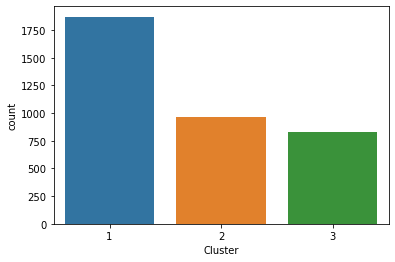

In [102]:
#First, let's look at the number of customers in each cluster
sns.countplot(x = 'Cluster', data = rfm_df_cluster)
plt.show()

Cluster 2 contains the most number of customers. Clusters 1 and 3 have a comparable number of customers.

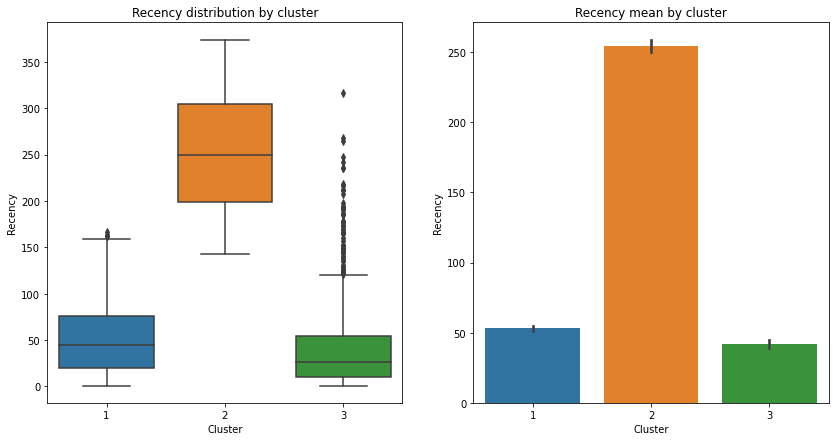

In [103]:
#Recency
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title("Recency distribution by cluster")
sns.boxplot(y = 'Recency', x = 'Cluster', data = rfm_df_cluster)

plt.subplot(1, 2, 2)
plt.title("Recency mean by cluster")
sns.barplot(y = 'Recency', x = 'Cluster', data = rfm_df_cluster)

plt.show()

The customers in cluster 2 have very high recency. Cluster 1 and 3 customers have low recency.

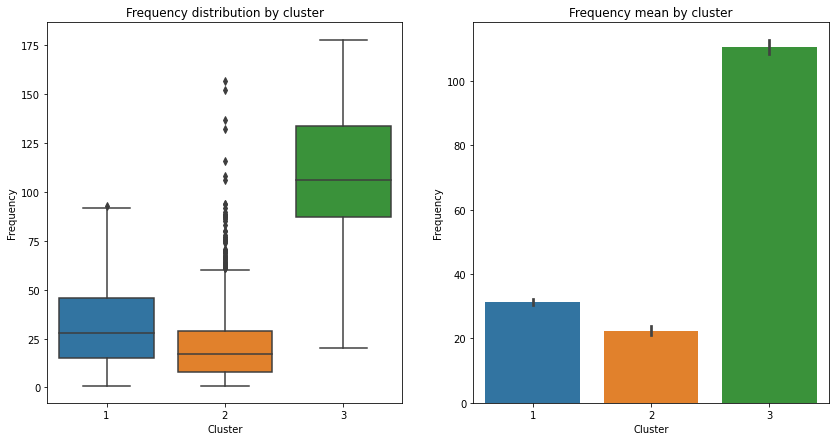

In [104]:
#Frequency
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title("Frequency distribution by cluster")
sns.boxplot(y = 'Frequency', x = 'Cluster', data = rfm_df_cluster)

plt.subplot(1, 2, 2)
plt.title("Frequency mean by cluster")
sns.barplot(y = 'Frequency', x = 'Cluster', data = rfm_df_cluster)

plt.show()

Cluster 3 customers have the highest frequency. This is frequency measured over the ~12 months of available data.

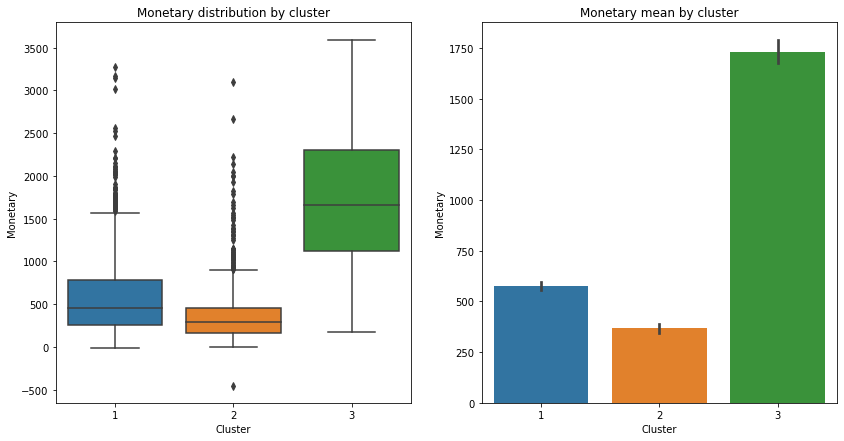

In [105]:
#Monetary
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title("Monetary distribution by cluster")
sns.boxplot(y = 'Monetary', x = 'Cluster', data = rfm_df_cluster)

plt.subplot(1, 2, 2)
plt.title("Monetary mean by cluster")
sns.barplot(y = 'Monetary', x = 'Cluster', data = rfm_df_cluster)

plt.show()

Cluster 3 customers have the highest monetary mean by far. Cluster 1 customers have the second highest monetary mean, but both clusters 1 and 3 have widespread monetary distributions.

### Conclusions

- The customers in cluster 3 have spent the most on the e-commerce site in the last year. They are also the most frequent customers, and their purchases have also been very recent. These customers are very valuable to the e-commerce site. They should be awarded loyalty points, so that they continue to shop on this site.

- The customers in cluster 2 have spent the least amount of money on the site, are the least frequent, and also have not made any recent purchases. They are also the second largest group of customers. The average customer in this group has made fewer than 25 purchases on this site and has not used this site in more than 200 days. This group should be given time-bound offers/discounts to entice them to return to this e-commerce site and use it more often.

- The cluster 1 customers have made purchases recently, but they rank low in the frequency and monetary measures. They form the largest of these three groups (by a significant margin). They can be given weekly or montly offers, to encourage them to use this e-commerce site regularly. This will gradually increase their total spend on the site.